In [1]:
from src.helpers.experiment import create_tsfresh_dataframe
from src.helpers.diabetes.cega import clarke_error_grid
from src.helpers.diabetes.madex import mean_adjusted_exponent_error
from pycaret.regression import setup, create_model, compare_models, predict_model
from loguru import logger
import warnings
import numpy as np
from sklearn.metrics import mean_squared_error
import pandas

In [2]:
train_parameters = {
    'ohio_no': 588,
    'scope': 'train',
    'train_ds_size': 0,
    'window_size': 12,
    'prediction_horizon': 1,
    'minimal_features': False,
}

unseen_data_parameters = {
    'ohio_no': 588,
    'scope': 'test',
    'train_ds_size': 0,
    'window_size': 12,
    'prediction_horizon': 1,
    'minimal_features': False,
}

# output = run_experiment(parameters, test_parameters)

2021-07-03 10:10:12.149 | INFO     | src.helpers.experiment:create_ds_name:12 - dataframes/588_train_0_12_1.pkl
2021-07-03 10:10:12.309 | INFO     | src.helpers.experiment:create_tsfresh_dataframe:19 - {'ohio_no': 588, 'scope': 'train', 'train_ds_size': 0, 'window_size': 12, 'prediction_horizon': 1, 'minimal_features': False}


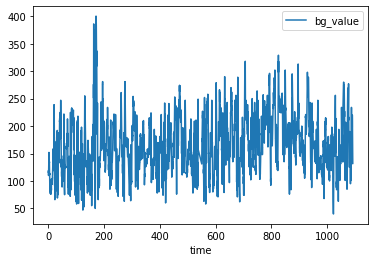

2021-07-03 10:10:12.714 | INFO     | src.helpers.experiment:create_tsfresh_dataframe:22 - Found existing picle file. Continuing...
2021-07-03 10:10:12.714 | INFO     | src.helpers.dataframe:read_df:11 - Attempting to read from pickle file dataframes/588_train_0_12_1.pkl


In [3]:
source_df = create_tsfresh_dataframe(train_parameters)
clean_df = source_df.drop(
    columns=['start', 'end', 'start_time', 'end_time'])

In [4]:
regressor = setup(clean_df,
    target='label',
    feature_selection=True,
    html=True,
    silent=True,
    session_id=1974
    )

,Description,Value
0,session_id,1974
1,Target,label
2,Original Data,"(12628, 788)"
3,Missing Values,True
4,Numeric Features,338
5,Categorical Features,449
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(8839, 301)"


In [5]:
best3 = compare_models(
    exclude=['catboost', 'xgboost'],
    sort='RMSE',
    n_select=3,
    verbose=True
)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,3.3384,34.7381,5.8228,0.9864,0.0382,0.0220,0.0510
lasso,Lasso Regression,3.3516,34.6296,5.8242,0.9864,0.0375,0.0221,0.3140
en,Elastic Net,3.3258,35.0354,5.8510,0.9862,0.0375,0.0219,0.3100
br,Bayesian Ridge,3.3392,37.6266,6.0542,0.9853,0.0393,0.0219,0.1630
lightgbm,Light Gradient Boosting Machine,3.9061,40.0592,6.2856,0.9843,0.0418,0.0258,0.9430
gbr,Gradient Boosting Regressor,4.3704,44.4294,6.6325,0.9826,0.0446,0.0288,8.5560
et,Extra Trees Regressor,4.0283,45.4764,6.7082,0.9822,0.0449,0.0268,10.5830
rf,Random Forest Regressor,4.4197,54.5342,7.3510,0.9786,0.0492,0.0295,20.2530
dt,Decision Tree Regressor,6.9406,130.9202,11.4058,0.9490,0.0746,0.0459,0.4220
ada,AdaBoost Regressor,9.3542,145.4613,12.0546,0.9432,0.0862,0.0640,3.7850


In [6]:
best3

[OrthogonalMatchingPursuit(fit_intercept=True, n_nonzero_coefs=None,
                           normalize=True, precompute='auto', tol=None),
 Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
       normalize=False, positive=False, precompute=False, random_state=1974,
       selection='cyclic', tol=0.0001, warm_start=False),
 ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
            max_iter=1000, normalize=False, positive=False, precompute=False,
            random_state=1974, selection='cyclic', tol=0.0001, warm_start=False)]

In [7]:
master_output = {}

In [8]:
def run_model(model_to_run):
    output = {}
    model = create_model(model_to_run)
    model_name = model.__str__().split('(')[0]
    logger.info(f'Processing model: {model_name}')
    output['model'] = model
    output['model_name'] = model_name
    pd = predict_model(model)
    (_, res) = clarke_error_grid(pd['label'], pd['Label'], 'Test')
    output['internal_cga_analysis'] = res
    rmse = np.sqrt(mean_squared_error(pd['label'], pd['Label']))
    rmadex = np.sqrt(mean_adjusted_exponent_error(
        pd['label'], pd['Label']))
    output['internal_rmse'] = rmse
    output['internal_rmadex'] = rmadex

    unseen_df = create_tsfresh_dataframe(unseen_data_parameters)
    clean_unseen_df = unseen_df.drop(
        columns=['start', 'end', 'start_time', 'end_time'])
    unseen_pd = predict_model(model, data=clean_unseen_df)
    (_, res) = clarke_error_grid(unseen_pd['label'], unseen_pd['Label'], 'Test')
    output['unseen_cga_analysis'] = res
    rmse = np.sqrt(mean_squared_error(unseen_pd['label'], unseen_pd['Label']))
    rmadex = np.sqrt(mean_adjusted_exponent_error(
        unseen_pd['label'], unseen_pd['Label']))
    output['unseen_rmse'] = rmse
    output['unseen_rmadex'] = rmadex
    logger.info(output)
    master_output[model_name] = output
    # df_array.append()
    

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,3.2485,26.9706,5.1933,0.9895,0.0341,0.0214
1,3.3017,33.3233,5.7726,0.9875,0.0348,0.0212
2,3.2492,26.5598,5.1536,0.9893,0.0360,0.0224
3,3.3387,40.8183,6.3889,0.9844,0.0383,0.0215
4,3.8639,64.8533,8.0532,0.9746,0.0496,0.0246
5,3.3418,29.4960,5.4310,0.9896,0.0400,0.0230
6,3.4530,44.4045,6.6637,0.9805,0.0363,0.0214
7,3.3445,29.7031,5.4501,0.9884,0.0433,0.0221
8,3.1347,26.7678,5.1738,0.9894,0.0351,0.0211
9,3.1086,24.4842,4.9481,0.9904,0.0346,0.0213


2021-07-03 10:18:31.702 | INFO     | __main__:run_model:5 - Processing model: OrthogonalMatchingPursuit


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,3.2274,29.2546,5.4088,0.9884,0.0397,0.0216


2021-07-03 10:18:32.000 | INFO     | src.helpers.experiment:create_ds_name:12 - dataframes/588_test_0_12_1.pkl
2021-07-03 10:18:32.039 | INFO     | src.helpers.experiment:create_tsfresh_dataframe:19 - {'ohio_no': 588, 'scope': 'test', 'train_ds_size': 0, 'window_size': 12, 'prediction_horizon': 1, 'minimal_features': False}


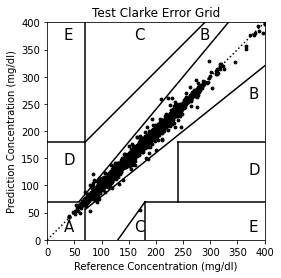

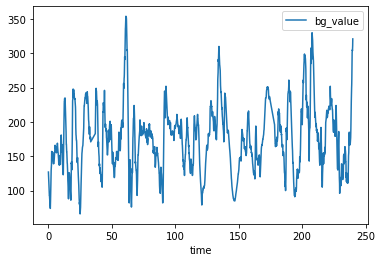

2021-07-03 10:18:32.311 | INFO     | src.helpers.experiment:create_tsfresh_dataframe:22 - Found existing picle file. Continuing...
2021-07-03 10:18:32.312 | INFO     | src.helpers.dataframe:read_df:11 - Attempting to read from pickle file dataframes/588_test_0_12_1.pkl
2021-07-03 10:18:33.419 | INFO     | __main__:run_model:28 - {'model': OrthogonalMatchingPursuit(fit_intercept=True, n_nonzero_coefs=None,
                          normalize=True, precompute='auto', tol=None), 'model_name': 'OrthogonalMatchingPursuit', 'internal_cga_analysis': [3776, 11, 1, 1, 0], 'internal_rmse': 5.408754796677673, 'internal_rmadex': 13.495228140911191, 'unseen_cga_analysis': [2777, 2, 0, 0, 0], 'unseen_rmse': 4.092793393723316, 'unseen_rmadex': 4.462732071075052}


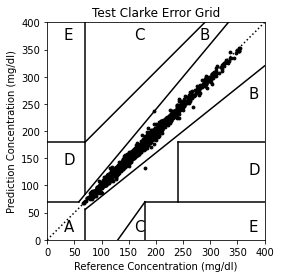

In [9]:
run_model(best3[0])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,3.2941,27.8000,5.2726,0.9892,0.0347,0.0217
1,3.3028,35.7662,5.9805,0.9866,0.0351,0.0212
2,3.2812,29.6685,5.4469,0.9881,0.0372,0.0226
3,3.3313,37.8288,6.1505,0.9855,0.0378,0.0218
4,3.7681,60.4021,7.7719,0.9764,0.0482,0.0241
5,3.2815,28.1903,5.3095,0.9901,0.0392,0.0226
6,3.5242,46.9213,6.8499,0.9794,0.0367,0.0219
7,3.4031,28.0391,5.2952,0.9890,0.0355,0.0223
8,3.1939,26.6903,5.1663,0.9895,0.0351,0.0216
9,3.1362,24.9893,4.9989,0.9902,0.0359,0.0217


2021-07-03 10:18:37.555 | INFO     | __main__:run_model:5 - Processing model: Lasso


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Regression,3.2908,29.3815,5.4205,0.9883,0.0399,0.0221


2021-07-03 10:18:37.920 | INFO     | src.helpers.experiment:create_ds_name:12 - dataframes/588_test_0_12_1.pkl
2021-07-03 10:18:37.939 | INFO     | src.helpers.experiment:create_tsfresh_dataframe:19 - {'ohio_no': 588, 'scope': 'test', 'train_ds_size': 0, 'window_size': 12, 'prediction_horizon': 1, 'minimal_features': False}


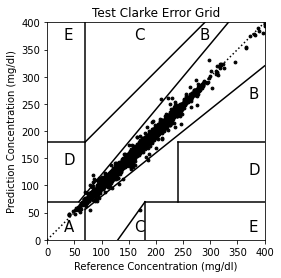

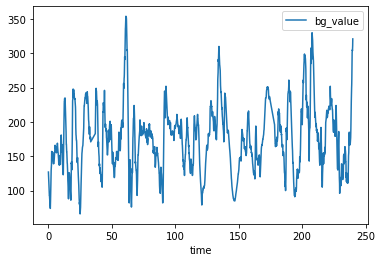

2021-07-03 10:18:38.202 | INFO     | src.helpers.experiment:create_tsfresh_dataframe:22 - Found existing picle file. Continuing...
2021-07-03 10:18:38.203 | INFO     | src.helpers.dataframe:read_df:11 - Attempting to read from pickle file dataframes/588_test_0_12_1.pkl
2021-07-03 10:18:39.356 | INFO     | __main__:run_model:28 - {'model': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=1974,
      selection='cyclic', tol=0.0001, warm_start=False), 'model_name': 'Lasso', 'internal_cga_analysis': [3774, 13, 1, 1, 0], 'internal_rmse': 5.4204717, 'internal_rmadex': 13.461962890122544, 'unseen_cga_analysis': [2777, 2, 0, 0, 0], 'unseen_rmse': 4.145320387651092, 'unseen_rmadex': 4.466650332700916}


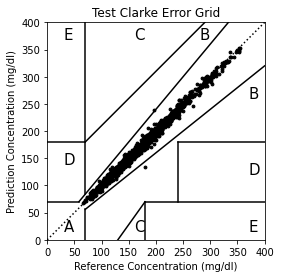

In [10]:
run_model(best3[1])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,3.2672,27.6360,5.2570,0.9892,0.0344,0.0215
1,3.2839,37.2150,6.1004,0.9861,0.0352,0.0210
2,3.2417,29.1051,5.3949,0.9883,0.0369,0.0223
3,3.3103,39.5517,6.2890,0.9849,0.0382,0.0216
4,3.7756,63.2274,7.9516,0.9753,0.0494,0.0241
5,3.2429,28.1938,5.3098,0.9901,0.0390,0.0222
6,3.4864,46.2334,6.7995,0.9797,0.0366,0.0216
7,3.3816,27.9836,5.2900,0.9890,0.0355,0.0222
8,3.1699,26.6487,5.1622,0.9895,0.0348,0.0213
9,3.0980,24.5589,4.9557,0.9903,0.0353,0.0214


2021-07-03 10:18:43.301 | INFO     | __main__:run_model:5 - Processing model: ElasticNet


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Elastic Net,3.2464,28.9474,5.3803,0.9885,0.0395,0.0217


2021-07-03 10:18:43.628 | INFO     | src.helpers.experiment:create_ds_name:12 - dataframes/588_test_0_12_1.pkl
2021-07-03 10:18:43.646 | INFO     | src.helpers.experiment:create_tsfresh_dataframe:19 - {'ohio_no': 588, 'scope': 'test', 'train_ds_size': 0, 'window_size': 12, 'prediction_horizon': 1, 'minimal_features': False}


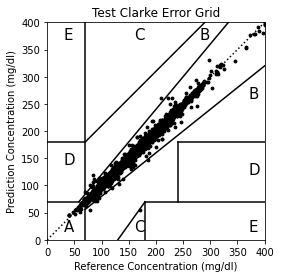

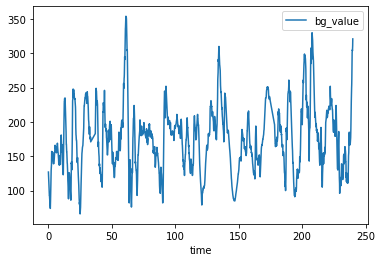

2021-07-03 10:18:43.915 | INFO     | src.helpers.experiment:create_tsfresh_dataframe:22 - Found existing picle file. Continuing...
2021-07-03 10:18:43.915 | INFO     | src.helpers.dataframe:read_df:11 - Attempting to read from pickle file dataframes/588_test_0_12_1.pkl
2021-07-03 10:18:45.043 | INFO     | __main__:run_model:28 - {'model': ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=1974, selection='cyclic', tol=0.0001, warm_start=False), 'model_name': 'ElasticNet', 'internal_cga_analysis': [3774, 13, 1, 1, 0], 'internal_rmse': 5.3802805, 'internal_rmadex': 13.397241641270478, 'unseen_cga_analysis': [2777, 2, 0, 0, 0], 'unseen_rmse': 4.109076254898715, 'unseen_rmadex': 4.428743610961747}


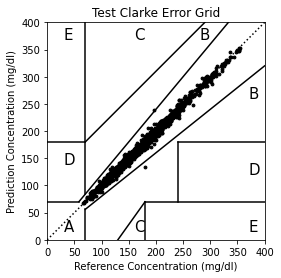

In [11]:
run_model(best3[2])

In [12]:
print(master_output)

{'OrthogonalMatchingPursuit': {'model': OrthogonalMatchingPursuit(fit_intercept=True, n_nonzero_coefs=None,
                          normalize=True, precompute='auto', tol=None), 'model_name': 'OrthogonalMatchingPursuit', 'internal_cga_analysis': [3776, 11, 1, 1, 0], 'internal_rmse': 5.408754796677673, 'internal_rmadex': 13.495228140911191, 'unseen_cga_analysis': [2777, 2, 0, 0, 0], 'unseen_rmse': 4.092793393723316, 'unseen_rmadex': 4.462732071075052}, 'Lasso': {'model': Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=1974,
      selection='cyclic', tol=0.0001, warm_start=False), 'model_name': 'Lasso', 'internal_cga_analysis': [3774, 13, 1, 1, 0], 'internal_rmse': 5.4204717, 'internal_rmadex': 13.461962890122544, 'unseen_cga_analysis': [2777, 2, 0, 0, 0], 'unseen_rmse': 4.145320387651092, 'unseen_rmadex': 4.466650332700916}, 'ElasticNet': {'model': ElasticNet(alpha=1.0, copy_X=True, fit_intercept=Tr

In [13]:
pandas.DataFrame.from_dict(master_output, orient='index')

,model,model_name,internal_cga_analysis,internal_rmse,internal_rmadex,unseen_cga_analysis,unseen_rmse,unseen_rmadex
OrthogonalMatchingPursuit,"OrthogonalMatchingPursuit(fit_intercept=True, ...",OrthogonalMatchingPursuit,"[3776, 11, 1, 1, 0]",5.408755,13.495228,"[2777, 2, 0, 0, 0]",4.092793,4.462732
Lasso,"Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...",Lasso,"[3774, 13, 1, 1, 0]",5.420472,13.461963,"[2777, 2, 0, 0, 0]",4.145320,4.466650
ElasticNet,"ElasticNet(alpha=1.0, copy_X=True, fit_interce...",ElasticNet,"[3774, 13, 1, 1, 0]",5.380280,13.397242,"[2777, 2, 0, 0, 0]",4.109076,4.428744


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d560f233-0034-499f-bc4e-7ada8795cb9f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>